## San Diego COVID-19 Projections

For the past few weeks, the San Diego Regional Data Library has been scraping the offical COVID statistics from the County of San Diego. The data package is in the [Library's data repository](https://data.sandiegodata.org/dataset/sandiegodata-org-covid19-1-2-0/). Along with other data in the Library's collection, we now have neough observations to produce some estimates of the future growth of cases in the County 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf


In [2]:

pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-covid19-1.2.0.csv') # .0 references the last upload
df = pkg.resource('sd_covid_cases').dataframe().fillna(0)
df.drop(columns=['notes'], inplace=True)
df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df.rename(columns={'hospitalized': 'hosp'}, inplace=True)
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp, df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths, df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)


df.head().T

/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


,0,1,2,3,4
date,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
cases,8,10,20,39,55
cases_male,0,0,0,19,35
cases_female,0,0,0,20,20
hosp,0,0,0,12,10
intensive_care,0,0,0,0,0
deaths,0,0,0,0,0
day,0,1,2,3,4
cases_rate,NaN,0.25,1,0.95,0.410256
cases_smooth,-12.063,5.28966,23.0314,41.1485,59.6185


[  25.17457152   15.7952714  1310.73349258 1284.75680563] [ 0.24017615  0.15882538 26.12537163 25.1142258 ]


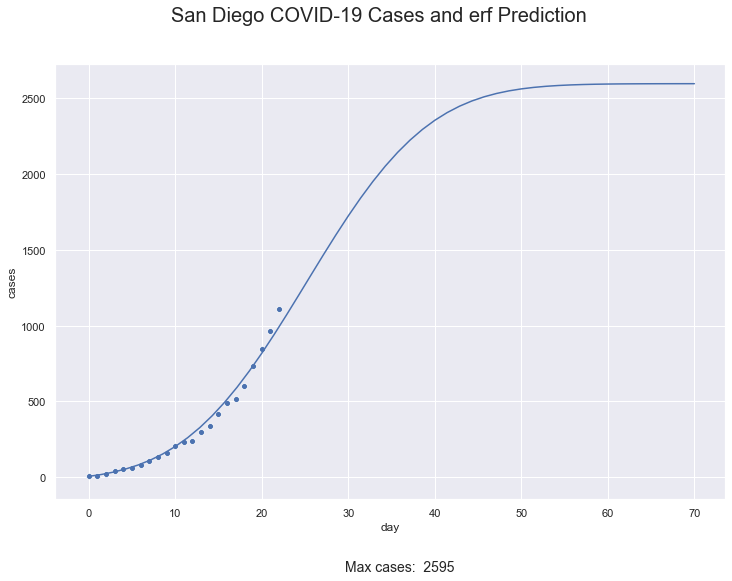

In [3]:

def ln_fit(df, fig, ax, col_name, use_smooth=True, pred_days = 70):

    t = df.dropna(subset=['day',col_name])

    def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
        return a*logistic.cdf(x, loc, scale)
    func_logistic.popt =  (14,4, 800)
    
    
    def func_erf(x, loc, scale, a, b):
        return a*erf( (x-loc) / scale ) + b
    func_erf.popt = (50,20,3000,3000)


    fit_func = func_erf

    fit_col = col_name+'_smooth' if use_smooth else col_name
    
    popt, pcov = curve_fit(fit_func, t.day, t[fit_col], p0=fit_func.popt, absolute_sigma = True)
   
    x=np.linspace(0,pred_days)
    proj = fit_func(x, *popt)
    
    sns.lineplot(x=x, y=proj, ax=ax)
    
    sns.scatterplot(x='day', y=col_name, data=t, ax=ax)

    perr = np.sqrt(np.diag(pcov))
    
    max_cases = np.max(proj)
    
    plt.gcf().text(.46,-0,f"Max {col_name}: {max_cases:5.0f}", fontsize=14) 

    
    return popt, perr, x, proj

fig, ax = plt.subplots(figsize=(12,8))

t = df.copy()
#t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1]

popt, perr, x, cases_d = ln_fit(t[:], fig, ax, 'cases')

print(popt, perr)
fig.suptitle("San Diego COVID-19 Cases and erf Prediction", fontsize=20);


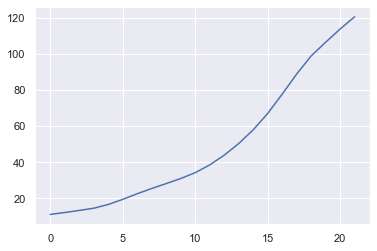

In [4]:
t = df.copy()
t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1] 
td = lowess(t.cases.diff(), df.day, is_sorted=True, frac=0.4, it=0)[:,1]

plt.plot(td)

#plt.plot(tr.cumsum())


In [5]:
df.date.max()

Timestamp('2020-04-03 00:00:00')

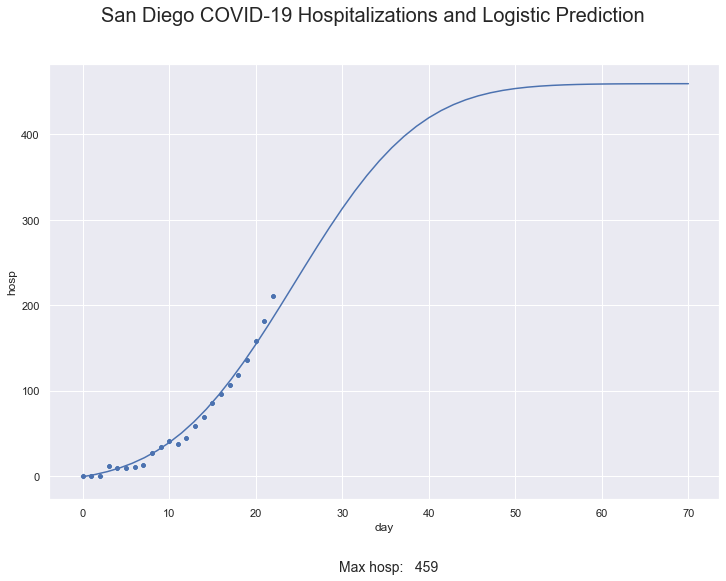

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, hosp_d = ln_fit(df, fig, ax, 'hosp')
fig.suptitle("San Diego COVID-19 Hospitalizations and Logistic Prediction", fontsize=20);

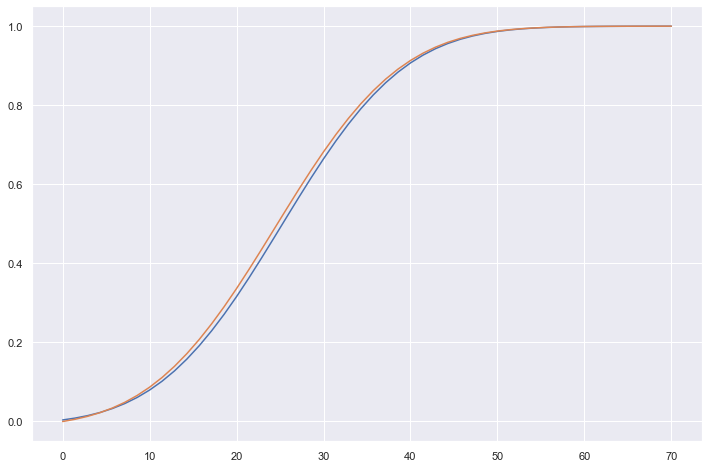

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x, cases_d/cases_d.max())
sns.lineplot(x, hosp_d/hosp_d.max())
#ax.set_xlim(20,30)
#ax.set_ylim(.6,.8)

/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


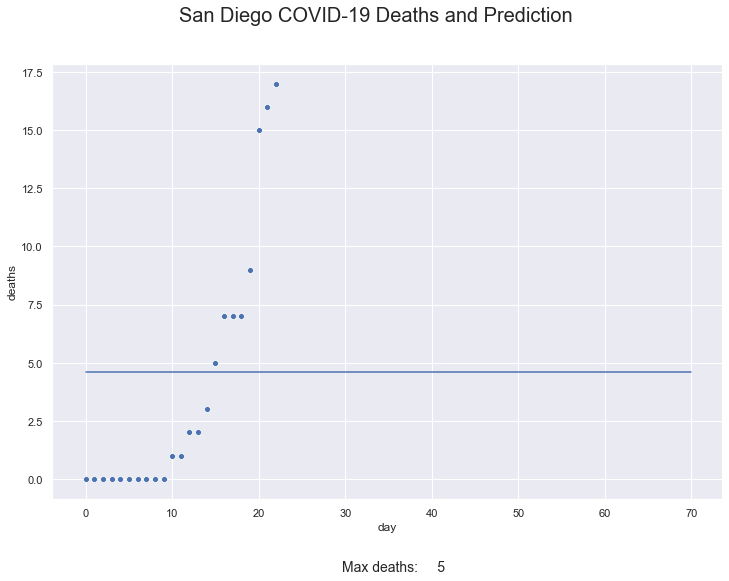

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, death_d = ln_fit(df, fig, ax, 'deaths')
fig.suptitle("San Diego COVID-19 Deaths and Prediction", fontsize=20);

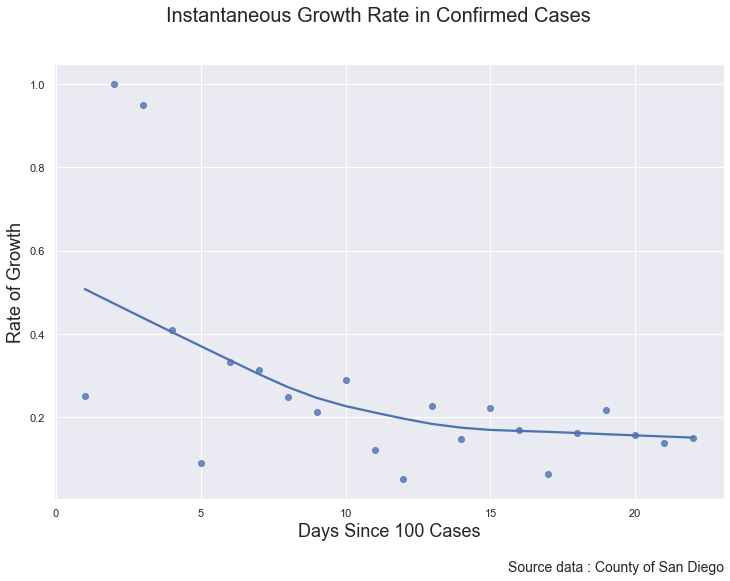

Coefficients: [[-0.02197754]] [0.52222329]
Zero growth at 23.761683014478358 days


In [9]:


def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)
    y = df[col].values.reshape(len(df), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df, lowess=True)

    #ax.plot(x, regr.predict(x), color='blue', linewidth=3)

    ax.set_xlabel('Days Since 100 Cases', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    print(f"Zero growth at {-b/m} days")

plot_gr(df.dropna(subset=['cases_rate']), 'cases_rate')
    

In [10]:
pkg = mp.open_package('http://library.metatab.org/covidtracking.com-covid19-2.1.0.csv')

states_df = pkg.resource('states').dataframe()

,27,26,25,24,23
date,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00
state,CA,CA,CA,CA,CA
positive,53,53,60,69,88
negative,462,462,462,462,462
pending,NaN,NaN,NaN,NaN,NaN
hospitalized,NaN,NaN,NaN,NaN,NaN
death,NaN,NaN,NaN,NaN,NaN
total,515,515,522,531,550
hash,10e497c4befea3c4ba15820ec029ed6606ac592e,1c08667f3dbe01bbda51406ed5af89cc1c881f7c,a25cea9de8ea0b3f6d30a5f7674df54919024f40,cd6090d40d0c975c4cd7141ba29b4e015c137124,8510829f28ad836f082ab8784a0af7ed9730f845
datechecked,2020-03-04 21:00:00,2020-03-05 21:00:00,2020-03-06 21:00:00,2020-03-07 21:00:00,2020-03-08 20:00:00


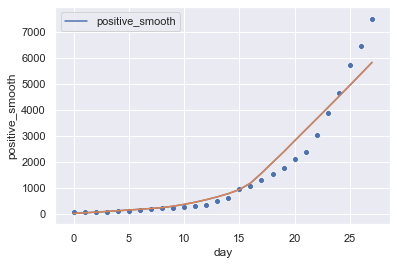

In [11]:
ca = states_df[states_df.state == 'CA'].copy().reset_index(drop=True)

ca['date'] = pd.to_datetime(ca.date, format='%Y%m%d' )
ca.sort_values('date', inplace=True)
ca.reset_index(drop=True)
ca['day'] = (ca.date - ca.date.min()).dt.days
ca['positive_smooth'] = lowess(ca.positive, ca.day)[:,1]

ca.head().T
ca.plot(x='day',y='positive_smooth')
sns.scatterplot(ca.day, ca.positive)
sns.lineplot(ca.day, ca.positive_smooth)
ca.head().T

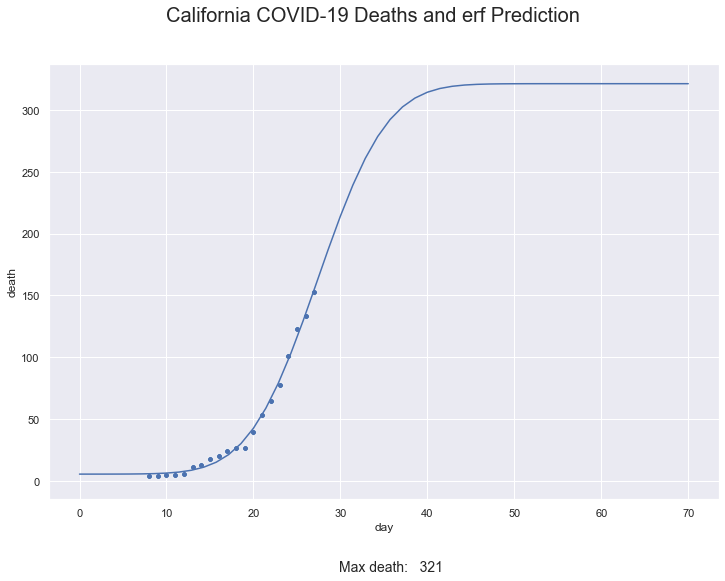

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, lnd  = ln_fit(ca, fig, ax, 'death', use_smooth=False, pred_days=70)
fig.suptitle("California COVID-19 Deaths and erf Prediction", fontsize=20);

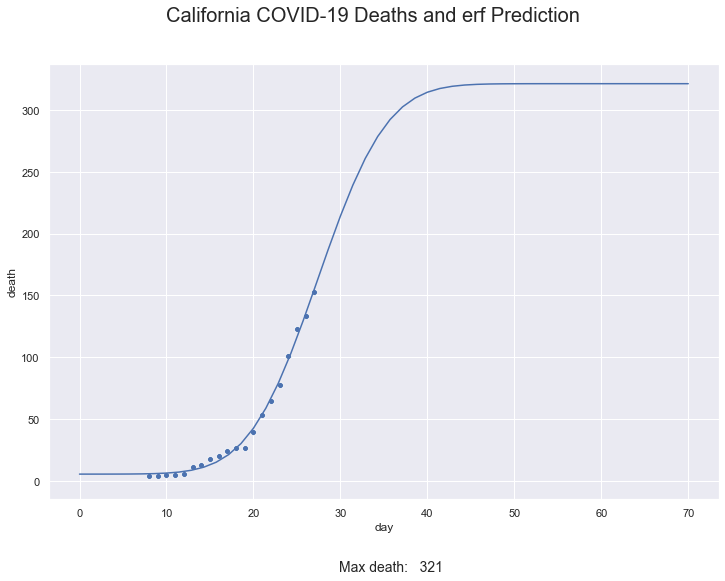

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, lnd  = ln_fit(ca, fig, ax, 'death', use_smooth=False, pred_days=70)
fig.suptitle("California COVID-19 Deaths and erf Prediction", fontsize=20);

In [14]:
ihme = pd.read_csv('hospitalization_all_locs_corrected.csv', parse_dates=True)

In [15]:
t = ihme[ihme.location_name == 'California'].copy()
t['date_reported'] = pd.to_datetime(t.date_reported)
t['day'] = (t.date_reported - ca.date.min()).dt.days
t.max().T

location_name             California
date_reported    2020-08-04 00:00:00
allbed_mean                  15242.2
allbed_lower                 3131.39
allbed_upper                 38097.9
ICUbed_mean                  2317.64
ICUbed_lower                 490.518
ICUbed_upper                 5787.06
InvVen_mean                  1251.66
InvVen_lower                 263.697
InvVen_upper                 3114.09
deaths_mean                  147.712
deaths_lower                      31
deaths_upper                     371
admis_mean                      1237
admis_lower                  261.579
admis_upper                  3120.53
newICU_mean                  291.916
newICU_lower                  61.867
newICU_upper                   734.1
totdea_mean                  6108.77
totdea_lower                  777.65
totdea_upper                 17163.1
bedover_mean                       0
bedover_lower                      0
bedover_upper                11443.9
icuover_mean                 324.639
i

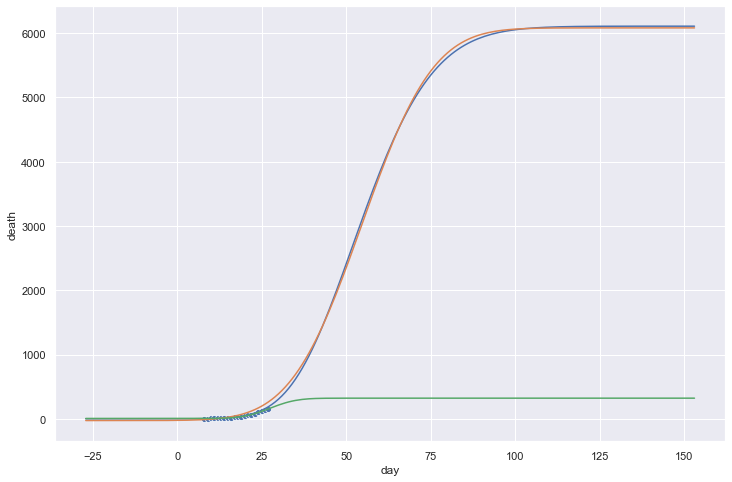

In [16]:
t = ihme[ihme.location_name == 'California'].copy()
t['date_reported'] = pd.to_datetime(t.date_reported)
t['day'] = (t.date_reported - ca.date.min()).dt.days

fig, ax = plt.subplots(figsize=(12,8))


def func_logistic(x, loc, scale, a, b): # popt = (14,4, 800)
    return a*logistic.cdf(x+b, loc, scale)
func_logistic = (14,4, 800,0)

def func_norm(x, loc, scale, a, b):
    return a*norm.cdf(x, loc, scale) + b
func_norm.popt = (14,4, 800,0)

def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)


f = func_erf

popt, pcov = curve_fit(f, t.day, t.deaths_mean.cumsum(), p0=f.popt)

cat = ca.dropna(subset=['date','death'])

popt2, pcov = curve_fit(f, cat.day, cat.death, p0=popt)

ax.plot(t.day, t.deaths_mean.cumsum()) # Blue line, CA deaths estimate from IHME
sns.scatterplot(ca.day, ca.death, ax=ax) # Actual death points for CA
ax.plot(t.day, f(t.day, *popt)) # Orange curve fit to IHME estimate
ax.plot(t.day, f(t.day, *popt2)) # Curve fit to points



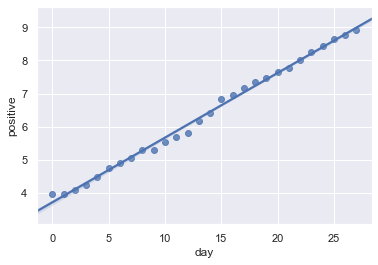

In [17]:
sns.regplot(ca.day, np.log(ca.positive))

In [18]:

x = ca.day.values.reshape(len(ca), 1)
y = np.log(ca.positive).values.reshape(len(ca), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Coefficients:', regr.coef_, regr.intercept_)
print("Correlation:", ca.day.corr(np.log(ca.positive)))

m = regr.coef_[0][0]
b = regr.intercept_[0]

Coefficients: [[0.19546458]] [3.71413865]
Correlation: 0.9977391978096573


In [19]:
np.log(2)/np.log(1+0.19546458)

3.8824188399451245

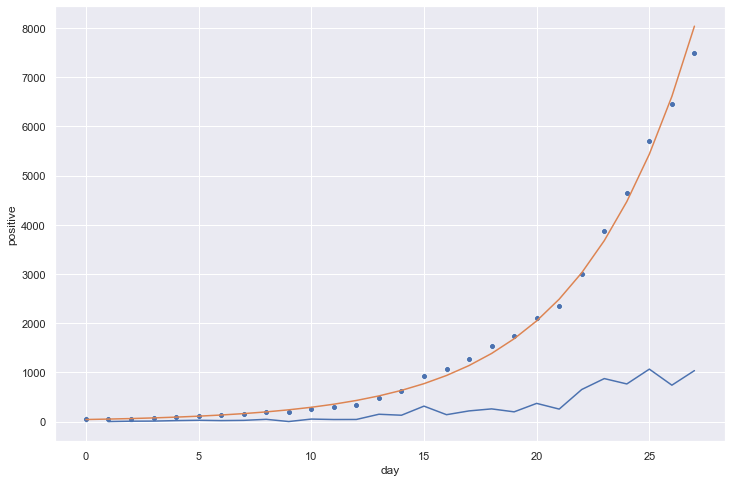

In [20]:
yp = np.exp(m*ca.day + b)

fig, ax = plt.subplots(figsize=(12,8))
#ax.plot(t.day, t.allbed_mean.cumsum())
sns.scatterplot(ca.day, ca.positive, ax=ax)
sns.lineplot(ca.day, ca.positive.diff(), ax=ax)
ax.plot(x,yp)

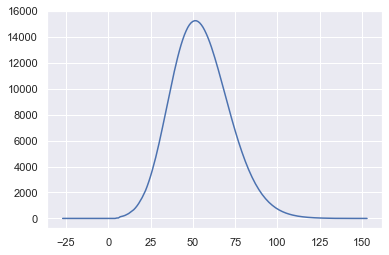

In [21]:
t = ihme[ihme.location_name == 'California'].copy()
t['date_reported'] = pd.to_datetime(t.date_reported)
t['day'] = (t.date_reported - ca.date.min()).dt.days
plt.plot(t.day, t.allbed_mean)
